# Load Data

In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.append('../')
import pandas as pd
import tqdm
import warnings
import copy
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import networkx as nx
import numpy as np
from collections import Counter
from collections import OrderedDict
import matplotlib.pyplot as plt

In [2]:
## Configure file and folder names
datafolder = "../data"
spadl_h5 = os.path.join(datafolder,"spadl-statsbomb.h5")

In [3]:
games = pd.read_hdf(spadl_h5,"games")
games = games[games.competition_name == "FIFA World Cup"]
print("nb of games:", len(games))

nb of games: 64


# Helper Functions

In [4]:
def teams_in_game(actions):
    team1 = actions.loc[0]["team_name"]
    for i in range(1, len(actions)):
        team2 = actions.loc[i]["team_name"]
        if (team2 != team1):
            return team1, team2

In [5]:
def game_pass_list(actions, team1):
    edges1 = []
    edges2 = []
    pass_action = ['pass', 'throw_in', 'corner_crossed', 'freekick_crossed', 'cross', 
                  'freekick_short', 'goalkick', 'corner_short']
    
    for i in range(len(actions)):
        action = actions.loc[i]["type_name"]
          
        if action in pass_action:
            if actions.loc[i]["result_name"] == 'success':
                passer = actions.loc[i]["player_name"]
                team = actions.loc[i]["team_name"]
                j = 1
                while i+j < len(actions) and (actions.loc[i+j]["team_name"] != team):
                    j += 1
                try:
                    passer = actions.loc[i]["player_name"]
                    receiver = actions.loc[i+j]["player_name"]
                    if team == team1:
                        edges1.append((passer, receiver))
                    else:
                        edges2.append((passer, receiver))
                except:
                    continue
                
    return edges1, edges2

In [6]:
def create_graph(passes):
    G = nx.DiGraph((x, y, {'weight': v}) for (x, y), v in Counter(passes).items())
    return G

In [7]:
def get_total_links(G):
    DV = G.degree(weight='weight')
    return sum(deg for n, deg in DV)/2

In [8]:
def get_metrics(G):
    total_links = get_total_links(G)
    density = nx.density(G)
    diameter = nx.diameter(G.to_undirected())
    average_clustering = nx.average_clustering(G)
    
    return total_links, density, diameter, average_clustering

In [48]:
def compute_average(team_props):
    average = {}
    
    for team in team_props:
        average[team] = [np.mean(team_props[team][0]), np.mean(team_props[team][1]), 
                         np.mean(team_props[team][2]), np.mean(team_props[team][3])]
    
    return average

In [66]:
def world_cup_team_placements():
    placements = {}
    placements['France'] = 1.5
    placements['Croatia'] = 1.5
    placements['Belgium'] = 3.5
    placements['England'] = 3.5
    placements['Uruguay'] = 6.5
    placements['Brazil'] = 6.5
    placements['Russia'] = 6.5
    placements['Sweden'] = 6.5
    placements['Portugal'] = 12.5
    placements['Argentina'] = 12.5
    placements['Mexico'] = 12.5
    placements['Japan'] = 12.5
    placements['Spain'] = 12.5
    placements['Denmark'] = 12.5
    placements['Switzerland'] = 12.5
    placements['Colombia'] = 12.5
    placements['Saudi Arabia'] = 24.5
    placements['Iran'] = 24.5
    placements['Peru'] = 24.5
    placements['Nigeria'] = 24.5
    placements['Serbia'] = 24.5
    placements['South Korea'] = 24.5
    placements['Tunisia'] = 24.5
    placements['Senegal'] = 24.5
    placements['Egypt'] = 24.5
    placements['Morocco'] = 24.5
    placements['Australia'] = 24.5
    placements['Iceland'] = 24.5
    placements['Costa Rica'] = 24.5
    placements['Germany'] = 24.5
    placements['Panama'] = 24.5
    placements['Poland'] = 24.5
    
    return placements

# Compute Network Metrics

In [67]:
players = pd.read_hdf(spadl_h5,"players")
teams = pd.read_hdf(spadl_h5,"teams")
actiontypes = pd.read_hdf(spadl_h5, "actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")
results = pd.read_hdf(spadl_h5, "results")

In [68]:
team_props = {}

for game in tqdm.tqdm(list(games.itertuples())):
    actions = pd.read_hdf(spadl_h5,f"actions/game_{game.game_id}")
    actions = (
        actions.merge(actiontypes)
        .merge(results)
        .merge(bodyparts)
        .merge(players,"left",on="player_id")
        .merge(teams,"left",on="team_id")
        .sort_values(["period_id", "time_seconds", "timestamp"])
        .reset_index(drop=True)
    )
    
    team1, team2 = teams_in_game(actions)
    
    if team1 is np.nan or team2 is np.nan:
        continue
    
    passes1, passes2 = game_pass_list(actions, team1)
    G1 = create_graph(passes1)
    G2 = create_graph(passes2)
    
    total_links1, density1, diameter1, avg_clustering1 = get_metrics(G1)
    total_links2, density2, diameter2, avg_clustering2 = get_metrics(G2)

    if team1 in team_props:
        team_props[team1][0].append(total_links1)
        team_props[team1][1].append(density1)
        team_props[team1][2].append(diameter1)
        team_props[team1][3].append(avg_clustering1)
    else:
        team_props[team1] = [[total_links1], [density1], [diameter1], [avg_clustering1]]
        
    if team2 in team_props:
        team_props[team2][0].append(total_links2)
        team_props[team2][1].append(density2)
        team_props[team2][2].append(diameter2)
        team_props[team2][3].append(avg_clustering2)
    else:
        team_props[team2] = [[total_links2], [density2], [diameter2], [avg_clustering2]]   

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [01:08<00:00,  1.06s/it]


In [69]:
average = compute_average(team_props)
placements = world_cup_team_placements()

In [70]:
ordered_teams = OrderedDict(sorted(average.items(), key=lambda x: x[1][0], reverse=True))
for team in ordered_teams:
    print(team + " (" + str(placements[team]) + ") : " + str(ordered_teams[team]))

Spain (12.5) : [786.0, 0.6552197802197802, 2.0, 0.785654480098664]
Germany (24.5) : [593.6666666666666, 0.6593406593406593, 2.0, 0.7889003350525345]
Saudi Arabia (24.5) : [517.0, 0.6120268620268621, 2.3333333333333335, 0.7443915208806587]
Argentina (12.5) : [512.75, 0.6673534798534799, 2.0, 0.7570395346429591]
Brazil (6.5) : [497.8, 0.6472527472527473, 2.0, 0.7465819832397076]
England (3.5) : [489.0, 0.6595499738356881, 2.2857142857142856, 0.7760790014603869]
Switzerland (12.5) : [462.5, 0.6298076923076923, 2.25, 0.7554852317895516]
Belgium (3.5) : [461.0, 0.641156462585034, 2.142857142857143, 0.7461537669158632]
Croatia (1.5) : [458.0, 0.5968079539508111, 2.142857142857143, 0.7119460227003334]
Japan (12.5) : [440.75, 0.6009615384615384, 2.5, 0.7129468375689421]
Australia (24.5) : [426.6666666666667, 0.5732600732600733, 2.0, 0.7137396237322484]
Poland (24.5) : [412.6666666666667, 0.6105006105006104, 2.0, 0.7257510048489794]
Portugal (12.5) : [407.5, 0.6002747252747254, 2.5, 0.735171064

# Placements

In [71]:
import scipy.stats as stats

In [79]:
place = [24.5, 12.5, 6.5, 3.5, 1.5]

total_links = {}
density = {}
diameter = {}
clustering_coefficient = {}

for p in place:
    total_links[p] = []
    density[p] = []
    diameter[p] = []
    clustering_coefficient[p] = []
    
for team in team_props:
    total_links[placements[team]] += team_props[team][0]
    density[placements[team]] += team_props[team][1]
    diameter[placements[team]] += team_props[team][2]
    clustering_coefficient[placements[team]] += team_props[team][3]
    
for p in place:
    print("Placement:", p)
    print("Total Links:", np.mean(total_links[p]))
    print("Density:", np.mean(density[p]))
    print("Diameter:", np.mean(diameter[p]))
    print("Clustering Coefficient:", np.mean(clustering_coefficient[p]))
    print()

Placement: 24.5
Total Links: 342.7916666666667
Density: 0.5703601953601954
Diameter: 2.3541666666666665
Clustering Coefficient: 0.6987253764041558

Placement: 12.5
Total Links: 462.90625
Density: 0.6218063186813187
Diameter: 2.15625
Clustering Coefficient: 0.7377248362269654

Placement: 6.5
Total Links: 344.6
Density: 0.5739743589743589
Diameter: 2.15
Clustering Coefficient: 0.6825927493233626

Placement: 3.5
Total Links: 475.0
Density: 0.6503532182103611
Diameter: 2.2142857142857144
Clustering Coefficient: 0.7611163841881252

Placement: 1.5
Total Links: 417.7142857142857
Density: 0.5884353741496599
Diameter: 2.2142857142857144
Clustering Coefficient: 0.7038111372684414



# Group vs Knockout ANOVA Test

In [102]:
net1 = []
net2 = []
net3 = []
net4 = []
for i in range(1, len(place)):
    net1 += total_links[place[i]]
    net2 += density[place[i]]
    net3 += diameter[place[i]]
    net4 += clustering_coefficient[place[i]]

f_scores = []    

f_scores.append(stats.f_oneway(total_links[24.5], net1))
f_scores.append(stats.f_oneway(density[24.5], net2))
f_scores.append(stats.f_oneway(diameter[24.5], net3))
f_scores.append(stats.f_oneway(clustering_coefficient[24.5], net4))

for f in f_scores:
    print(f)

F_onewayResult(statistic=11.208317356248294, pvalue=0.001074080419304197)
F_onewayResult(statistic=10.358496012695651, pvalue=0.0016388990566032627)
F_onewayResult(statistic=5.385934899204735, pvalue=0.021906607577012526)
F_onewayResult(statistic=4.217350345894587, pvalue=0.042081490091037094)


# Quarters vs Semifinals ANOVA Test

In [103]:
f_scores = []    

f_scores.append(stats.f_oneway(total_links[6.5], total_links[3.5]+total_links[1.5]))
f_scores.append(stats.f_oneway(density[6.5], density[3.5]+density[1.5]))
f_scores.append(stats.f_oneway(diameter[6.5], diameter[3.5]+diameter[1.5]))
f_scores.append(stats.f_oneway(clustering_coefficient[6.5], clustering_coefficient[3.5]+clustering_coefficient[1.5]))

for f in f_scores:
    print(f)

F_onewayResult(statistic=8.23741914710647, pvalue=0.006180933702802763)
F_onewayResult(statistic=4.728067985406065, pvalue=0.0348543753170518)
F_onewayResult(statistic=0.3053097345132743, pvalue=0.5832478241464716)
F_onewayResult(statistic=7.808965996018717, pvalue=0.007556010307061757)


# World Cup Regression 

In [75]:
from scipy import stats

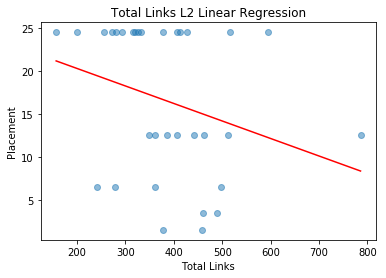

slope: -0.020380268049560026
r: -0.2891727772366525
p: 0.10844215155018194
std_err 0.012317695030015839



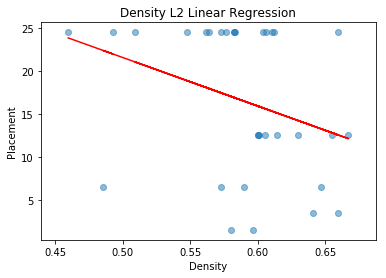

slope: -56.51000305208243
r: -0.3264506886629396
p: 0.0682222868031707
std_err 29.87289877615414



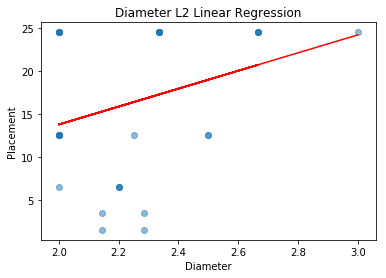

slope: 10.437333748837915
r: 0.3156193570023073
p: 0.07846369403954354
std_err 5.729006287691948



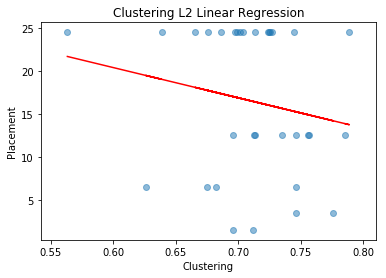

slope: -35.2426733065353
r: -0.1892252746000871
p: 0.29962388024147735
std_err 33.389601727743276



In [76]:
metrics = ["Total Links", "Density", "Diameter", "Clustering"]

for i in range(4):

    X = []
    y = []

    for team in ordered_teams:
        X.append(ordered_teams[team][i])
        y.append(placements[team])

    slope, intercept, r_value, p_value, std_err = stats.linregress(X,y)
    
    yPred1 = [intercept + slope * x for x in X]
    plt.scatter(X, y,alpha=0.5)
    plt.plot(X, yPred1, 'r', label="Linear")
    plt.title(metrics[i] + " L2 Linear Regression")
    plt.ylabel("Placement")
    plt.xlabel(metrics[i])
    plt.show()
    
    print("slope:", slope)
    print("r:", r_value)
    print("p:", p_value)
    print("std_err", std_err)
    print()